In [1]:
import keras
print keras.__version__
from keras.models import *
import vgg16
from keras.utils.data_utils import get_file
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


Using Theano backend.
/home/hyz/.virtualenvs/myenv/local/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "


2.0.7


Using cuDNN version 7001 on context None
Mapped name None to device cuda: GeForce GTX 1060 6GB (0000:01:00.0)


In [2]:
v = vgg16.Vgg16()
fname = 'vgg16.h5'
FILE_PATH = 'http://files.fast.ai/models/'
v.model.load_weights(get_file(fname, FILE_PATH+fname, cache_subdir='models'))

vgg16.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
vgg16.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
vgg16.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
vgg16.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))


In [3]:
v.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [4]:
import numpy as np
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D 
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


In [5]:
img_height = 224
img_width = img_height
batch_size=16

In [6]:
v.model.pop()
for layer in v.model.layers:
    layer.trainable=False
v.model.add(Dense(10, activation='softmax'))
#v.model.layers[-2].trainable= True
#v.model.layers[-3].trainable= True

v.model.summary()
v.model.load_weights('weights-improvement-3--97-0.97.hdf5')
#v.model.load_weights('weights-improvement-3--03-0.70.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [7]:
train_datagen = ImageDataGenerator()
                                   #shear_range = 0.1,
                                   #zoom_range = 0.1,
                                   #            )

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('sub/train',
                                                 target_size = (img_height, img_width),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('sub/val',
                                            target_size = (img_height, img_width),
                                            batch_size = batch_size,
                                            class_mode = 'categorical', shuffle=False)
filepath="weights-improvement-3--{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

v.model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])



Found 20435 images belonging to 10 classes.
Found 1989 images belonging to 10 classes.


(3, 224, 224)
(3, 224, 224)


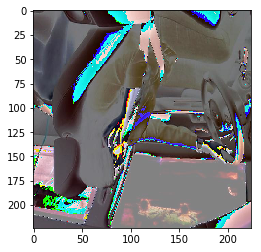

In [8]:
img = training_set.next()
print img[0][0].shape
vgg_mean = np.array([128, 128, 128], dtype=np.float32).reshape((3,1,1))

x = img[0][0] - vgg_mean
x = x[:, ::-1]
print x.shape
plt.imshow(np.rollaxis(x, 0, 3))

In [9]:
#v.model.summary()
v.model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples/batch_size,
                         epochs = 00,
                         validation_data = test_set,
                         validation_steps = test_set.samples/batch_size, callbacks=callbacks_list)

In [10]:
import csv 
submit_datagen = ImageDataGenerator() #'sub/test'
b = 32
submit_set = submit_datagen.flow_from_directory('sub/test', target_size=(img_width, img_height),
                                                batch_size=b, class_mode=None, shuffle=False)

print submit_set.samples, submit_set.batch_size, submit_set.samples / b + 1
preds = v.model.predict_generator(submit_set, 
                                  submit_set.samples / b + 1, verbose=1
                                  )
print len(preds)
preds = np.clip(preds, 0.001, 0.999)

with open('submission2.csv', 'w') as csvfile:
  csvw = csv.writer(csvfile)
  csvw.writerow(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
  for fn, sc in zip(submit_set.filenames, preds):
    csvw.writerow([fn.split('/')[1]] + list(sc))


Found 79726 images belonging to 1 classes.
79726 32 2492
2492/2492 [==============================] - 874s   
79726


In [11]:
t = submit_set.next()


In [12]:
v.model.predict(t)

array([[  9.13896739e-01,   1.97731929e-08,   8.99659867e-15,
          4.37400216e-04,   1.81970131e-02,   1.85801764e-04,
          1.46259282e-07,   1.18285783e-18,   1.74718312e-04,
          6.71081841e-02],
       [  1.66589142e-08,   1.25962504e-11,   2.78157949e-13,
          1.59166561e-07,   9.99996185e-01,   9.98591771e-19,
          3.68676456e-06,   3.67054342e-13,   9.92107818e-09,
          6.70298395e-09],
       [  2.36322275e-17,   2.78673385e-18,   4.72345170e-15,
          3.27974244e-19,   6.67483579e-14,   1.00000000e+00,
          3.68818687e-09,   1.23643055e-19,   7.23285139e-16,
          6.74994931e-14],
       [  3.08742971e-29,   1.63228719e-12,   1.00000000e+00,
          1.27136481e-27,   4.68437440e-28,   1.21404345e-26,
          2.54004619e-15,   4.54088308e-17,   1.72220987e-10,
          4.04948524e-23],
       [  8.25932261e-07,   3.92671495e-08,   5.17618717e-13,
          1.15641228e-06,   2.24303087e-09,   2.12904916e-09,
          2.44976910e-08

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
t[0].shape
#plt.imshow(t[0])

(3, 224, 224)